<a href="https://colab.research.google.com/github/RiboRings/neurogenomics/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Neurogenomics Project 2

In [2]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from itertools import combinations
from matplotlib import pyplot as plt

## Part 1: Normalization of sequencing data

### TMM Normalization

In [3]:
 # Read the file
pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)

In [4]:
# Define a function that gets 2 gene expression vectors X & Y and a constant D,
# and normalizes vector Y to vector X using TMM normalization, then plot them

def TMM_normalization(X, Y, D=0.2):

  # Find indices where both X and Y are non-zero
  idx0 = np.where((X != 0) & (Y != 0))
  X = X[idx0]
  Y = Y[idx0]

  M = np.log(Y / X)  # Compute M folds
  Wi = np.sqrt((X + Y) / 2)  # Compute weights

  # Compute the lower and upper quantiles
  lower_quantile = np.quantile(M, D/2)
  upper_quantile = np.quantile(M, 1 - D / 2)

  # Select data points that fall within the quantiles
  D_2 = np.where((M > lower_quantile) & (M < upper_quantile))
  trimed_m = M[D_2]
  trimed_Wi = Wi[D_2]

  # Sort trimmed M and weights values
  sorted_idx = np.argsort(trimed_m)
  sorted_m = trimed_m[sorted_idx]
  sorted_w = trimed_Wi[sorted_idx]

  # Compute TMM
  tmm = np.sum(sorted_w * sorted_m) / np.sum(sorted_w)
  # Compute normalization factor
  factor = np.exp(tmm)
  # Normalize Y vector to X vecor by dividing it values by the normalization factor
  normalized_Y = Y / factor

  # Plot histograms before and after normalization
  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before TMM normalization")
  axes[0].legend()

  axes[1].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[1].hist(normalized_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after TMM normalization")
  axes[1].legend()

  plt.tight_layout()

  return X, normalized_Y, factor

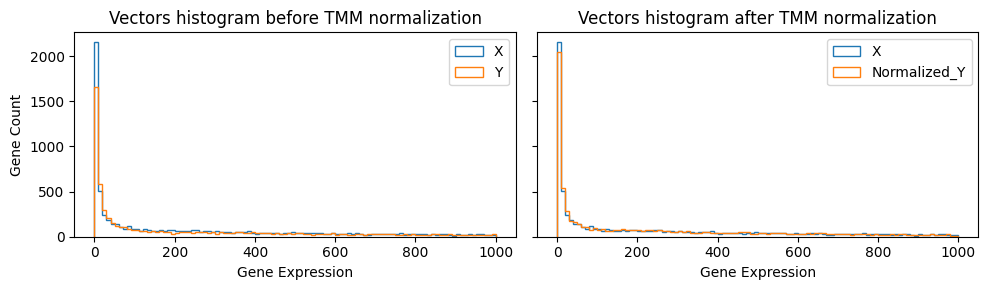

In [5]:
# Plot histograms with vectors from the pasilla dataset

X = pasilla["untreated1"].to_numpy()
Y = pasilla["untreated2"].to_numpy()

X, norm_Y, factor = TMM_normalization(X, Y)

### Quantile Normalization

In [7]:
# Define a function that gets 2 gene expression vectors X & Y, and normalizes them using Quantile Normalisation, then plot them

def quantile_normalisation(X, Y):

  # Transpose the matrix
  A = np.vstack([X, Y]).T

  # Order of elements in each column
  order = A.argsort(axis=0)
  # Indices/ranks of sorted elements in each column
  ranks = order.argsort(axis=0)

  # Sort matrix by column
  sorted_A = np.sort(A, axis=0)
  # Compute the mean of each row
  row_mean = np.mean(sorted_A, axis=1)

  # New matrix for normalized values
  norm_A = np.zeros_like(A).astype(float)

  # Assign mean values to the relevant ranks
  for rank in range(row_mean.size):
    norm_A[ranks == rank] = row_mean[rank]

  # Split the normalized matrix back into two vectors
  norm_X, norm_Y = norm_A[:, 0], norm_A[:, 1]

  # Plot histograms before and after normalization
  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before Quantile normalization")
  axes[0].legend()

  axes[1].hist(norm_X, bins=100, range=[0, 1000], histtype="step", label="Normalized_X")
  axes[1].hist(norm_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after Quantile normalization")
  axes[1].legend()

  plt.tight_layout()

  return norm_X, norm_Y

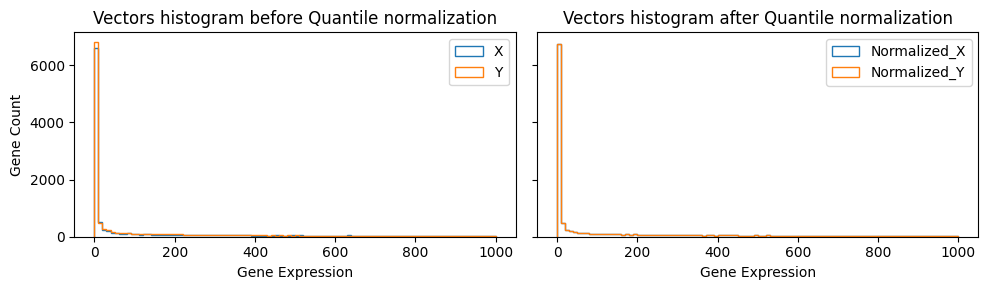

In [8]:
# Plot histograms with vectors from the pasilla dataset

pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)
X = pasilla["untreated1"].to_numpy()
Y = pasilla["treated2"].to_numpy()

norm_X, norm_Y = quantile_normalisation(X, Y)

## Part 2: Detect rhythmical patterns using Fourier transform

### Section 1

In [35]:
# Read the files
circ_df = pd.read_csv("CircadianRNAseq.csv")

# Preprocess data and convert to numpy array
circ_df.index = circ_df['GeneSymbol'].astype('str').str.cat(circ_df.groupby('GeneSymbol').cumcount().add(1).astype('str'), sep='_')
circ_df = circ_df.drop(columns=["RefSeqID", "GeneSymbol"])
circ_mat = circ_df.to_numpy()

In [156]:
# These is our code from task 1, right?

# Detect genes that have circadian expression based on G factor using FFT
def compute_powers(mat, rmna=True):

  # Perform FFT
  powers = fft(mat, axis=1)
  powers = np.abs(powers) ** 2

  powers = powers[:, 1:(1 + powers.shape[1] // 2)]
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)

  circ_powers = norm_powers[:, 1]

  if rmna:
    mat = mat[~np.isnan(circ_powers), :]
    circ_powers = circ_powers[~np.isnan(circ_powers)]

  return circ_powers, mat

In [79]:
# Define function to compute survivor function of circadian genes
def generate_survivor(powers):

  threshold_range = np.arange(0, 1, 0.01)
  cdf = []

  for threshold in threshold_range:

    genes = np.where(powers >= threshold, 1, 0)
    cdf.append(genes.sum())

  cdf = np.array(cdf)

  return cdf, threshold_range

In [82]:
# Compute powers of real matrix
circ_powers, circ_mat = compute_powers(circ_mat)
# Obtain survivor function for real matrix
real_survivor, threshold_range = generate_survivor(circ_powers)

<ipython-input-81-3daa8e58efb9>:11: RuntimeWarning: invalid value encountered in divide
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)


### Sections 2 and 3

Row-wise shuffling should be preferred over column-wise shuffling, because the former preserves the mean expression and variance of each gene while disrupting its cyrcadian rhythm, so that the effect of shuffling exclusively targets rhythmicity and not other biological properties of the genes. In addition, row-wise shuffling should require less computational demand, as the items to shuffle are fewer than for column-wise shuffling.

In [85]:
# Define function to shuffle matrix by axis

def shuffle_along_axis(mat, axis):

  idx = np.random.rand(*mat.shape).argsort(axis=axis)
  shuffled_mat = np.take_along_axis(mat, idx, axis=axis)

  return shuffled_mat

# Shuffle real matrix
shuffled_mat = shuffle_along_axis(circ_mat, axis=1)
# Compute powers of shuffled matrix
shuffled_powers, _ = compute_powers(shuffled_mat)
# Obtain survivor function for shuffled matrix
shuffled_survivor, _ = generate_survivor(shuffled_powers)

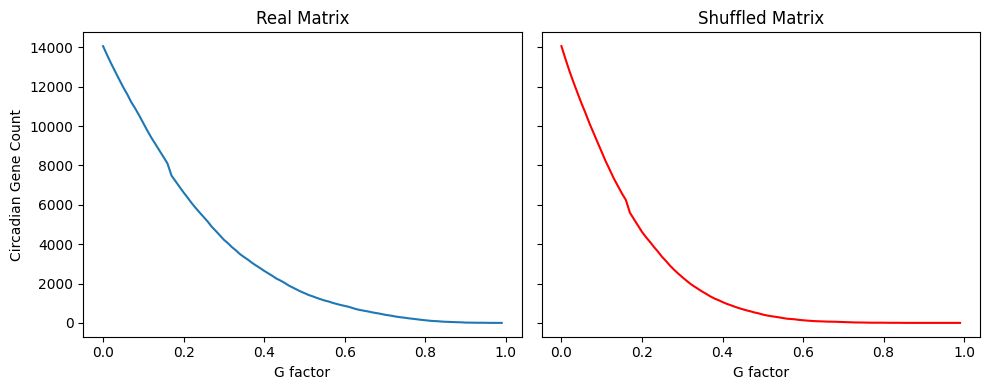

In [86]:
# Plot both the original dataset and permuted dataset

fig, axes = plt.subplots(1, 2, sharey=True)

fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(threshold_range, real_survivor)

axes[0].set_xlabel("G factor")
axes[0].set_ylabel("Circadian Gene Count")
axes[0].set_title("Real Matrix")

axes[1].plot(threshold_range, shuffled_survivor, color = "red")

axes[1].set_xlabel("G factor")
axes[1].set_title("Shuffled Matrix")

plt.tight_layout()

### Sections 4 and 5

In [88]:
# Repeat permutation for 100 times
sim = 100
power_list = []

for i in range(sim):

  shuffled_mat = shuffle_along_axis(circ_mat, axis=0)
  shuffled_powers, _ = compute_powers(shuffled_mat)

  power_list.append(shuffled_powers)

power_arr = np.array(power_list)

Text(0, 0.5, 'Circadian Gene Count')

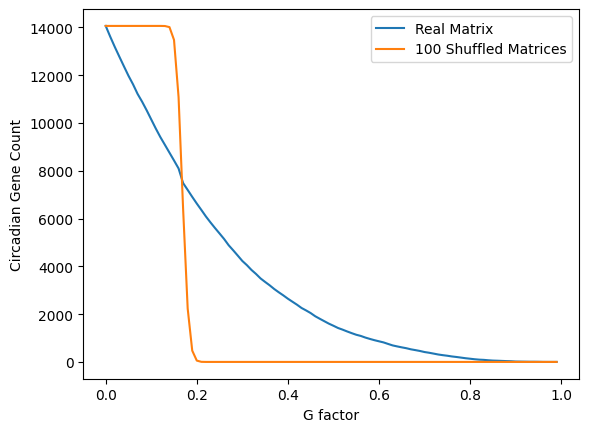

In [89]:
# Average the 100 resulting vectors
mean_powers = np.mean(power_arr, axis=0)
# Create the data set and plot it toghether with the original dataset
mean_survivor, _ = generate_survivor(mean_powers)

plt.plot(threshold_range, real_survivor, label = "Real Matrix")
plt.plot(threshold_range, mean_survivor, label = f"{sim} Shuffled Matrices")
plt.legend()

plt.xlabel("G factor")
plt.ylabel("Circadian Gene Count")

### Sections 6 and 7

In [100]:
# Calculate the fraction of true positives
true_positives1 = (real_survivor - shuffled_survivor) / real_survivor
true_positives2 = (real_survivor - mean_survivor) / real_survivor


<ipython-input-100-96ff12aef655>:2: RuntimeWarning: invalid value encountered in divide
  true_positives1 = (real_survivor - shuffled_survivor) / real_survivor
<ipython-input-100-96ff12aef655>:3: RuntimeWarning: invalid value encountered in divide
  true_positives2 = (real_survivor - mean_survivor) / real_survivor


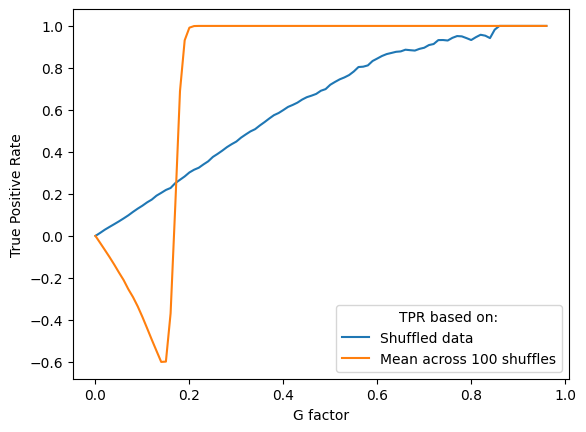

In [109]:
# Visualise TPR
plt.plot(threshold_range, true_positives1, label="Shuffled data")
plt.plot(threshold_range, true_positives2, label="Mean across 100 shuffles")

plt.xlabel("G factor")
plt.ylabel("True Positive Rate")
plt.legend(title="TPR based on:")

## Part 3: Hierarchical Clustering

First, we define a function to find the distance between pairs of genes.

In [22]:
# Define a function that computes Pearson's correlation between expression profile of 2 genes
def compute_pearson(x, y):
  n = x.size
  x_sum = np.sum(x)
  y_sum = np.sum(y)

  # Pearson's correlation formula
  r = (n * np.sum(x * y) - x_sum * y_sum) / np.sqrt((n * np.sum(x**2) - x_sum**2) * (n * np.sum(y**2) - y_sum**2))

  return r

# Define a function that computes the distance between genes and clusters
def compute_distance(x, y):
  r = compute_pearson(x, y)
  d = 1 - r
  return d

Next, we define a function to generate a distance matrix.

In [23]:
# Define a function that creates a distant matrix (N x N) using Perason's correlation, each value in the matrix represents the distance between 2 expression profiles of genes
def make_distance_matrix(mat):

  # Number of rows in the original matrix
  dim = mat.shape[0]
  # Find distance matrix
  D = np.zeros((dim, dim))

  # Find indices of the main diagonal of the matrix
  diag = np.diag_indices(dim)
  # Replace diagonal with NAs to avoid distance calculation with itself
  D[diag] = np.nan

   # All the relevant options for couples of rows in the matrix
  combos = combinations(range(dim), 2)

  # For each pair of indices (x, y), calculate the distance between the x row and the y row
  for x, y in combos:

    d = compute_distance(mat[x, :], mat[y, :])

    D[x, y] = d
    D[y, x] = d

  return D

Finally, we define a function to perform hierarchical clustering.

In [166]:
def hierarchical_clustering(mat, num_clusters):
    # Calculate pairwise distances between data points
    D = make_distance_matrix(mat)

    # Initialise clusters with each data point as a cluster
    clusters = [[i] for i in range(mat.shape[0])]

    # Merge clusters until the desired number of clusters is reached
    while len(clusters) > num_clusters:
        min_distance = np.inf
        merge_indices = None

        # Find the closest pair of clusters to merge
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                cluster_distance = np.mean(D[np.ix_(clusters[i], clusters[j])])
                if cluster_distance < min_distance:
                    min_distance = cluster_distance
                    merge_indices = (i, j)

        # Merge the closest pair of clusters
        clusters[merge_indices[0]].extend(clusters[merge_indices[1]])
        del clusters[merge_indices[1]]

    # Assign clusters to data points
    cluster_assignments = np.zeros(mat.shape[0])
    for i, cluster in enumerate(clusters):
        for data_point in cluster:
            cluster_assignments[data_point] = i

    cluster_assignments = cluster_assignments.astype(int)
    return cluster_assignments

The clustering algorithm is be applied to a subset oh highly circadian genes as follows with 6 clusters. We could not select genes based on the TPR, thus we instead filtered them by a G factor greater or equal to 0.8.

In [150]:
# Read the files
circ_df = pd.read_csv("CircadianRNAseq.csv")

# Preprocess data and convert to numpy array
circ_df.index = circ_df['GeneSymbol'].astype('str').str.cat(circ_df.groupby('GeneSymbol').cumcount().add(1).astype('str'), sep='_')
circ_df = circ_df.drop(columns=["RefSeqID", "GeneSymbol"])
circ_mat = circ_df.to_numpy()

In [180]:
# Find indices of genes with a G factor greater or equal to 0.8
circ_powers, _ = compute_powers(circ_mat, rmna=False)
keep_genes = np.where(circ_powers >= 0.8)

# Subset geneswith a G factor of 0.8 as threshold
selected_genes = circ_mat[keep_genes]
selected_names = circ_df.index[keep_genes].to_numpy()

# Cluster genes
cluster_assignments = hierarchical_clustering(selected_genes, 6)

<ipython-input-156-b4319f0f5c5b>:11: RuntimeWarning: invalid value encountered in divide
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)


In [179]:
# Combine clustered genes into dictionary
cluster_dict = {key: [] for key in set(cluster_assignments)}
for i in range(len(cluster_assignments)):
  cluster_dict[cluster_assignments[i]].append(selected_names[i])

# Print clustering results
for key, val in cluster_dict.items():

  print(key)
  print("\n")
  print(val)

0


['CRMP1_1.0', 'zgc:101722_1.0', 'zgc:158340_1.0', 'zgc:158292_1.0', 'slc43a2a_1.0', 'CDH17_1.0', 'zgc:162232_1.0', 'asap2a_1.0', 'KLHL18_1.0', 'STX6_1.0', 'nan_nan', 'zgc:92198_1.0', 'zgc:109782_1.0', 'zgc:109949_1.0', 'GXYLT1_1.0', 'nan_nan', 'zgc:158564_1.0', 'dtx1_1.0', 'zgc:113183_1.0']
1


['nan_nan', 'ankrd10a_1.0', 'NR3C2_1.0', 'AGPAT3_1.0', 'SMAD2_1.0', 'ttll6_1.0', 'ATP7A_1.0', 'Etfdh_1.0', 'Mbnl3_1.0', 'PLIN2_1.0', 'zgc:152863_1.0', 'HIP1_1.0', 'ODC1_1.0', 'ARNTL2_1.0', 'DENND4A_2.0', 'igf1ra_1.0', 'oscp1_1.0', 'atxn1b_1.0', 'si:dkeyp-114f9.4_1.0', 'mycl1b_1.0', 'cdc14aa_1.0', 'zgc:136547_1.0', 'zgc:172298_1.0', 'TMX3_1.0', 'CLOCK_1.0', 'zgc:153096_1.0', 'cry4_1.0', 'Dok6_1.0', 'c3orf58b_1.0', 'acbd5a_1.0', 'cul1b_1.0', 'arntl1a_1.0', 'fus_1.0', 'nan_nan', 'zgc:158220_1.0', 'grk1b_1.0', 'zgc:136755_1.0', 'zgc:100861_1.0', 'zgc:64031_1.0', 'GPT2_1.0', 'zgc:65987_1.0', 'zgc:162904_1.0', 'Fgf3_1.0', 'arntl1b_2.0', 'LOC560226_1.0', 'PRNP_1.0', 'si:dkey-72l14.9_1.0', 'tbl1x_1.